In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt

In [2]:
# load data
TrainingData = scio.loadmat('../generate_ligo/noise.mat') # only noise    
analysisData = scio.loadmat('../generate_ligo/data.mat') # noise + signal
# analysisData = scio.loadmat('TrainingData.mat') # only noise to check

## Preparing
# dataY = analysisData['dataVec'][0] # (2048,)
dataY = analysisData['data'][0]
dataY[-1] = dataY[-2] * 0.999
# dataY = analysisData['trainData'][0] # (2048,)1
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
# Fs = analysisData['sampFreq'][0,0] # 1024
Fs = analysisData['samples'][0]
# Fs = 1024

# Search range of phase coefficients
"""
        r,   m_c, tc,  phi_c,  w,   y
"""
rmin = [1e24,1e31,0,-2 * np.pi,1e32,0]
rmax = [3e24,2e31,1,2*np.pi,1e37,1]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
# t = np.arange(0, nSamples*dt, dt) # (2048,)
t = np.linspace(-10,0,nSamples)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
[f, pxx] = welch(TrainingData['noise'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False) 
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)

/home/ywq/anaconda3/envs/PSOlinux/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


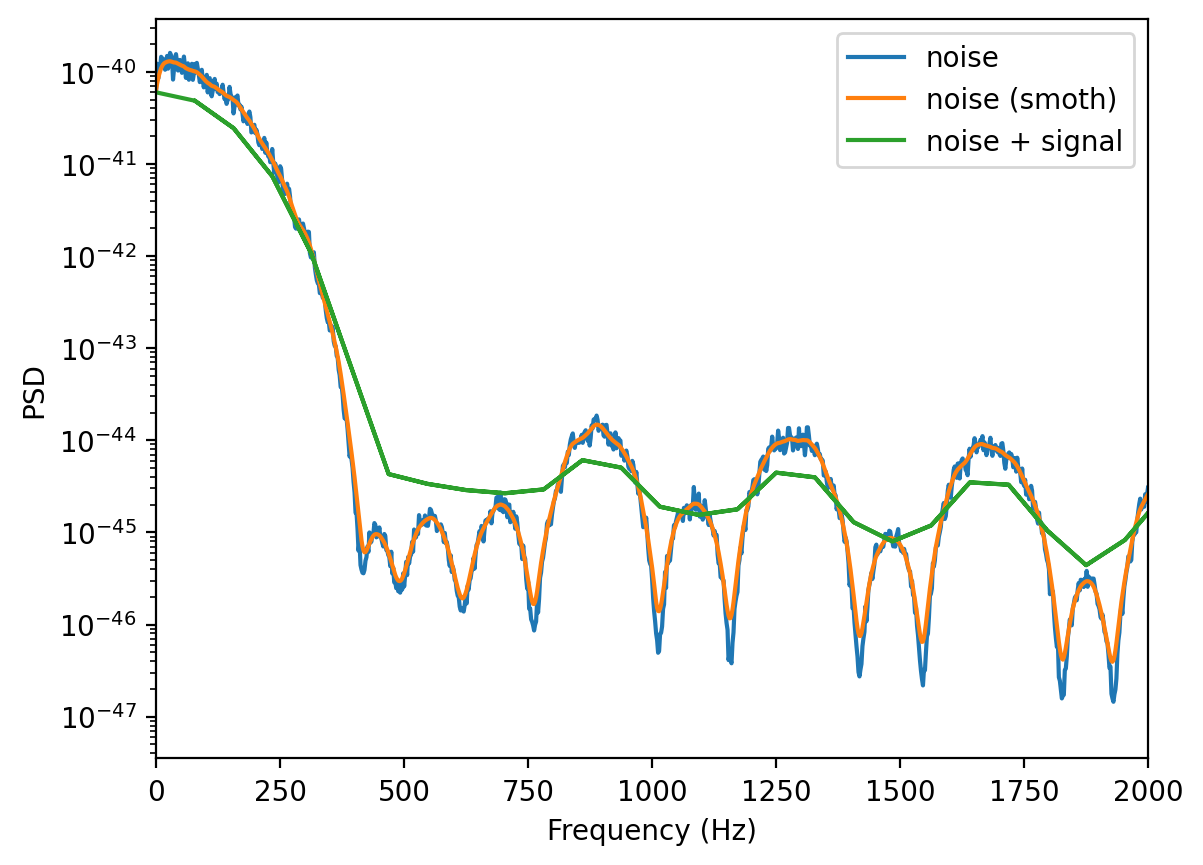

In [3]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=200)
plt.plot(f,pxx, label='noise')
plt.plot(f,pxxSmth, label='noise (smoth)')
[f, pxxY] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
plt.plot(np.abs(f),pxxY, label='noise + signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.yscale('log')
plt.xlim(0,2000)
plt.legend()
plt.savefig('output_psd.png', dpi=200)
plt.show()

In [4]:
# Number of independent PSO runs
nRuns = 8

In [5]:
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    # 'dataXSq': t**2,
    # 'dataXCb': t**3,
    'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from its
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 2000}, nRuns)

100%|██████████| 2000/2000 [25:05<00:00,  1.33it/s]


--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------


/home/ywq/anaconda3/envs/PSOlinux/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ywq/anaconda3/envs/PSOlinux/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


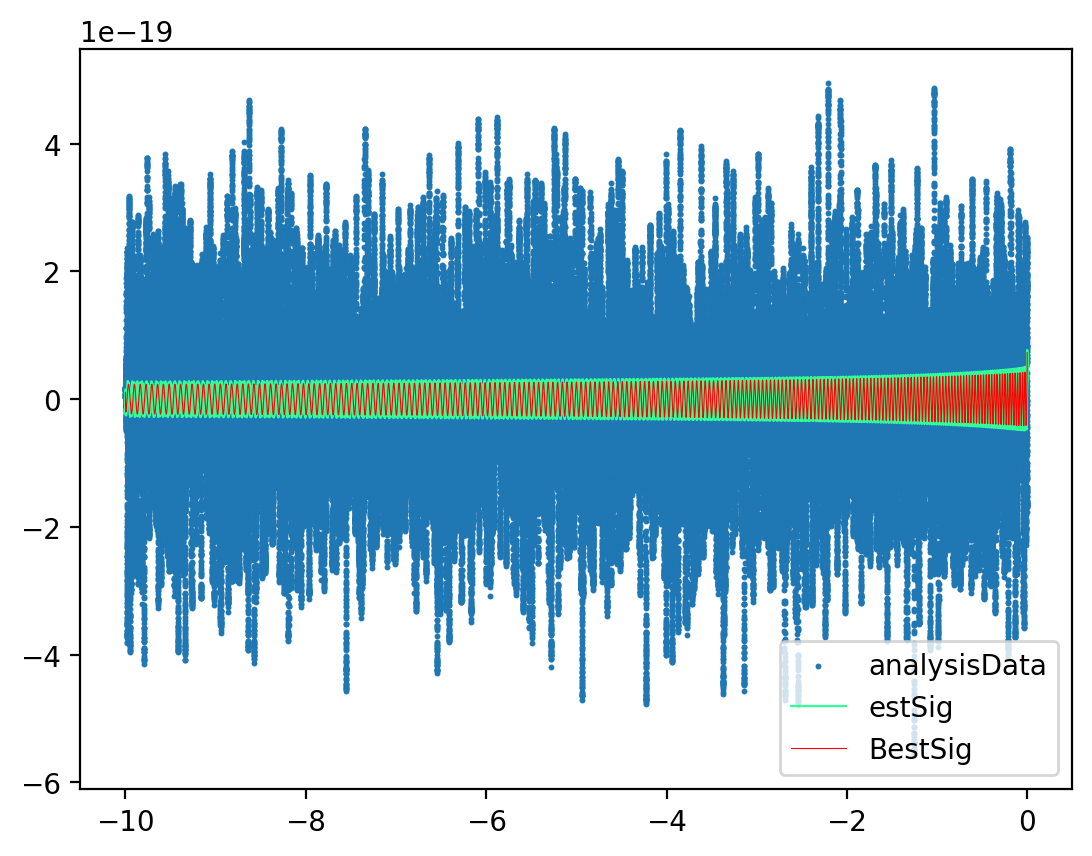

[ 1.07263719e-20 -1.44490516e-21 -1.38419231e-21 ...  6.04863910e-20
  6.06054185e-20  7.28725467e-20]


In [ ]:
## Plots
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
a=ax.scatter(t, dataY, marker='.', s=5, #label='analysisData'
             )
a.set_label('analysisData')
for lpruns in range(nRuns):
    b,=ax.plot(t, outResults['allRunsOutput'][lpruns]['estSig'],
             color=[51/255,255/255,153/255], lw=.4*2)
b.set_label('estSig')
c,=ax.plot(t, outResults['bestSig'], #label='BestSig',
         'red',lw=.2*2)
c.set_label('BestSig')
plt.legend()
plt.savefig('output_sig.png', dpi=200)
plt.show()
# print(outResults['allRunsOutput'][lpruns]['estSig'])

In [10]:
# Print estimated parameters
print('Estimated parameters:')
print('bestFitness = {:.4f}'.format(outResults['bestFitness']))
print('r = {:.4e}'.format(outResults['r']))
print('m_c = {:.4e}'.format(outResults['m_c'])) 
print('tc = {:.4f}'.format(outResults['tc']))
print('phi_c = {:.4f}'.format(outResults['phi_c']))
print('w = {:.4f}'.format(outResults['w']))
print('y = {:.4f}'.format(outResults['y']))

for lpruns in range(nRuns):
    print('\nRun No.{}:'.format(lpruns+1))
    print('bestFitness={:.2f}'.format(outStruct[lpruns]['bestFitness']))
    print('r = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['r']))
    print('m_c = {:.4e}'.format(outResults['allRunsOutput'][lpruns]['m_c']))
    print('tc = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['tc']))
    print('phi_c = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['phi_c']))
    print('w = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['w']))
    print('y = {:.4f}'.format(outResults['allRunsOutput'][lpruns]['y']))

# Save
np.save('output_results',outResults)
np.save('output_struct',outStruct)

Estimated parameters:
bestFitness = -1105.1083
r = 2.2920e+24
m_c = 1.8178e+31
tc = 1.0093
phi_c = 3.0053
w = 987144534786581548514819266425389056.0000
y = 0.7434

Run No.1:
bestFitness=-1102.53
r = 2.2221e+24
m_c = 1.1526e+31
tc = 3.5134
phi_c = -0.7819
w = 8703915386358360114682858708744011776.0000
y = 0.8283

Run No.2:
bestFitness=-1100.20
r = 2.0716e+24
m_c = 1.7164e+31
tc = 1.8423
phi_c = 3.0737
w = 1076554318940611257790820683494719488.0000
y = 0.7688

Run No.3:
bestFitness=-1103.78
r = 2.0066e+24
m_c = 1.8887e+31
tc = 0.2975
phi_c = -4.0308
w = 1236671554813406070844138322869092352.0000
y = 0.7033

Run No.4:
bestFitness=-1101.17
r = 1.9674e+24
m_c = 1.8717e+31
tc = 0.4609
phi_c = 3.6714
w = 6929376640477246005868202525412294656.0000
y = 0.8319

Run No.5:
bestFitness=-1098.72
r = 1.4451e+24
m_c = 1.7561e+31
tc = 0.4354
phi_c = -3.6354
w = 8774132878904428299486309397664104448.0000
y = 0.6207

Run No.6:
bestFitness=-1101.46
r = 2.0238e+24
m_c = 1.3389e+31
tc = 0.6584
phi_c = 2.922